In [17]:
"""
# transformer task 1

同じid列を再生成するタスク
ランダムで仮想文字列を作成して、再生成するタスク。
label_smoothing, schedulingなどの学習の工夫に関してはやってない。
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import model
import copy

max_itr = 100
checkout_itr = 10
batch_size = 5
word_len = 8 # 文章の長さ
vocab_num = 10
device = "cpu"
lr = 0.00005
batch_num = 10
n_minibatch = 8
max_epoch = 10

def generate_data(batch_size, word_len):
    """
    generate data of virtual sentence
    output:
        - src (torch.tensor) (batch_size, word_len) : virtual sentence 
        - tgt (torch.tensor) (batch_size, word_len) : same of src
    """
    data = torch.LongTensor(np.random.randint(1, vocab_num-1, size=(batch_size, word_len)))
    data[:,0] = vocab_num - 1 # 0はpadding用 start of sequence は文章中の単語じゃない方がいいかもしれない的なイメージ
    src = copy.deepcopy(data[:,1:])
    tgt = copy.deepcopy(data)
    # tgt_onehot = to_onehot(data, vocab_num)
    return src, tgt

def make_mask(word_len):
    """
    make mask of tgt data
    set 0 where you must not look, otherwise, set 1.

    # todo
    - we maybe need mask for padding, also.
    """
    mask = np.tril(np.ones((word_len,word_len))).astype(np.float32)
    mask = torch.tensor(mask)
    return mask

# def to_onehot(x, vocab_num):
#     e = np.eye(vocab_num).astype(np.float32)
#     onehot = torch.tensor(e[x])
#     return onehot

def culc_loss(loss_func, inputs, targets):
    """
    損失関数の計算
    args:
        - loss_func : 損失関数(交差エントロピー)
        - input (B x len x d): 入力データ
        - target (B x len): ターゲットデータ
    
    文章ごとに平均をとって、バッチごとに平均をとる
    pytorchの交差エントロピー使わない方が収束早いし、lossも小さくなる。。。
    どういうことだ？
    計算結果が微妙に違う気がするし、nn.CrossEntropyが所望の計算をしてない可能性ある？
    """
    B, l, d = inputs.shape
    _loss = 0
    loss = 0
    for i in range(B):
        loss += loss_func(inputs[i], targets[i])# 内部的に文章平均
        _loss += cross_ent(inputs[i], targets[i])
    _loss /= B# バッチ平均
    loss /= B
    return loss

def cross_ent(ipt, tgt):
    ans = 0
    for i in range(tgt.shape[0]):
       ans += - torch.log(ipt[i, tgt[i]])
    ans /= tgt.shape[0]
    return ans

class Batch():
    def __init__(self, batch_num, n_minibatch, word_len):
        self.data = []
        for i in range(batch_num):
            self.data.append(list(generate_data(n_minibatch, word_len)))

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return src, tgt

transformer = model.Model(device, 512, vocab_num, 0.0, 6, 6, 8, 8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=lr)
batch = Batch(batch_num, n_minibatch, word_len)
batch_test = Batch(1, 1, word_len)

loss_log = []

for j in range(max_epoch):
    for itr in range(batch_num):
        print("predcit")
        transformer.train()
        optimizer.zero_grad()
        src, tgt = batch[itr]
        # src : (16(B), 7(wordlen - 1))
        # tgt : (16(B), 8(wordlen)) 先頭は1(デコーダの最初の入力)
        mask = make_mask(word_len)

        out = transformer(src, tgt, mask)
        # out = transformer(src, tgt, None)
        loss = culc_loss(criterion, out[:,:-1,:], src)
        loss.backward()
        optimizer.step()
        print(f"epoch : {j}, itration : {itr}, loss : {loss}")
        print(src[0])
        print(torch.max(out[0,:-1,:], dim=-1)[1])
        transformer.eval()
        # src_, tgt_ = batch_test[0]
        src_, tgt_ = batch[itr][0][0], batch[itr][1][0]# 学習したデータすら再現できないので、実装がおかしい？
        src_ = src_.unsqueeze(0)
        tgt_ = tgt_.unsqueeze(0)
        predict = transformer.generate(src_)
        print("eval")
        print(src_[0])
        print(predict[0])
        loss_log.append(loss.tolist())
        # print(loss_log)
        
        



# ransformer.enc_dec.encoder.layers[0].multi_attention.linear_q.weight.grad
# transformer.gen.linear.weight.grad
# transformer.enc_dec.decoder.layers[5].feedforward.l2.weight.grad




predcit
epoch : 0, itration : 0, loss : 2.4888906478881836
tensor([8, 5, 1, 6, 6, 7, 4])
tensor([8, 8, 8, 8, 8, 8, 9])
eval
tensor([8, 5, 1, 6, 6, 7, 4])
tensor([7, 6, 7, 6, 7, 6, 7])
predcit
epoch : 0, itration : 1, loss : 2.322777271270752
tensor([4, 1, 1, 5, 6, 1, 5])
tensor([4, 4, 6, 6, 1, 4, 1])
eval
tensor([4, 1, 1, 5, 6, 1, 5])
tensor([4, 1, 6, 4, 1, 6, 4])
predcit
epoch : 0, itration : 2, loss : 1.8938058614730835
tensor([1, 5, 2, 8, 5, 1, 5])
tensor([5, 5, 5, 5, 5, 5, 5])
eval
tensor([1, 5, 2, 8, 5, 1, 5])
tensor([5, 5, 5, 5, 5, 5, 5])
predcit
epoch : 0, itration : 3, loss : 1.9563794136047363
tensor([4, 4, 1, 8, 4, 2, 5])
tensor([4, 1, 1, 4, 4, 1, 4])
eval
tensor([4, 4, 1, 8, 4, 2, 5])
tensor([1, 4, 1, 4, 1, 4, 1])
predcit
epoch : 0, itration : 4, loss : 1.7856427431106567
tensor([1, 6, 8, 4, 3, 8, 6])
tensor([8, 8, 8, 8, 6, 8, 8])
eval
tensor([1, 6, 8, 4, 3, 8, 6])
tensor([3, 3, 3, 3, 3, 3, 3])
predcit
epoch : 0, itration : 5, loss : 2.020068407058716
tensor([5, 2, 4, 8, 8, 

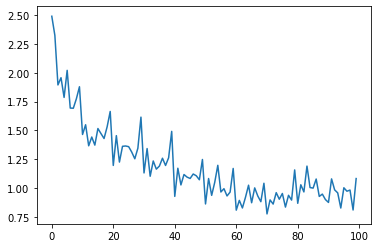

In [18]:
import matplotlib.pyplot as plt

plt.plot(loss_log)

In [14]:
loss.tolist()

1.8738328218460083